## Obtaining a dataset of agtech-related stories on Hacker News

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re  
import spacy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fangn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fangn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


I'll start with a wide query for any stories containing ag(-)/agri(-)/farm. From the initial larger dataset, I can then narrow them down to the stories related to ag(ri)tech (i.e. agricultural technology).

In [3]:
from google.cloud import bigquery

In [4]:
client = bigquery.Client()

query = """
SELECT title, type, score, descendants AS comments, timestamp, url
FROM `bigquery-public-data.hacker_news.full`
WHERE REGEXP_CONTAINS(title, r"(?:(a|A)g)(ri)(?:(\-|\ |))?") OR REGEXP_CONTAINS(title, r"\\b(a|A)g(\-)?\\b") OR REGEXP_CONTAINS(title, r"(f|F)arm")
ORDER BY timestamp
"""

ag_farm_df = client.query(query).to_dataframe()
ag_farm_df

,title,type,score,comments,timestamp,url
0,Possibility of running single-system-image clu...,story,1,1.0,2007-05-05 03:43:55+00:00,None
1,Life of a Chinese Gold Farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...
2,What's the best health insurance company for c...,story,1,3.0,2007-06-23 23:06:55+00:00,None
3,"""Crowd Farm"": turn the mechanical energy of pe...",story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html
4,Folding Farmer - Folding @ Home As A Service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...
...,...,...,...,...,...,...
4896,Rebuilding soil microbiomes in high-tunnel agr...,story,1,0.0,2021-02-11 23:20:49+00:00,https://phys.org/news/2021-02-rebuilding-soil-...
4897,Unstoppable eating machines: Aus farmers are r...,story,4,2.0,2021-02-12 23:33:35+00:00,https://www.theguardian.com/environment/2021/f...
4898,Farming Fish in the Sky,story,1,0.0,2021-02-14 22:34:00+00:00,https://www.hakaimagazine.com/news/farming-fis...
4899,India activist Disha Ravi arrested over farmer...,story,5,1.0,2021-02-15 00:26:25+00:00,https://www.bbc.com/news/world-asia-india-5606...


proposed sequence of steps:  
1. lowercase all words 
2. remove punctuation
3. convert into tokens
4. lemmatise (i.e. make them into root words)
5. create bigrams
6. prune bigrams containing stopwords

In [5]:
# convert all characters to lowercase in 
ag_farm_df['title']=ag_farm_df['title'].str.lower()
ag_farm_df

,title,type,score,comments,timestamp,url
0,possibility of running single-system-image clu...,story,1,1.0,2007-05-05 03:43:55+00:00,None
1,life of a chinese gold farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...
2,what's the best health insurance company for c...,story,1,3.0,2007-06-23 23:06:55+00:00,None
3,"""crowd farm"": turn the mechanical energy of pe...",story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html
4,folding farmer - folding @ home as a service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...
...,...,...,...,...,...,...
4896,rebuilding soil microbiomes in high-tunnel agr...,story,1,0.0,2021-02-11 23:20:49+00:00,https://phys.org/news/2021-02-rebuilding-soil-...
4897,unstoppable eating machines: aus farmers are r...,story,4,2.0,2021-02-12 23:33:35+00:00,https://www.theguardian.com/environment/2021/f...
4898,farming fish in the sky,story,1,0.0,2021-02-14 22:34:00+00:00,https://www.hakaimagazine.com/news/farming-fis...
4899,india activist disha ravi arrested over farmer...,story,5,1.0,2021-02-15 00:26:25+00:00,https://www.bbc.com/news/world-asia-india-5606...


In [6]:
# remove punctuation from title column
ag_farm_df['title'] = ag_farm_df['title'].str.replace('[^\w\s]','')
ag_farm_df

C:\Users\fangn\anaconda3\envs\hackernews\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,title,type,score,comments,timestamp,url
0,possibility of running singlesystemimage clust...,story,1,1.0,2007-05-05 03:43:55+00:00,None
1,life of a chinese gold farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...
2,whats the best health insurance company for ca...,story,1,3.0,2007-06-23 23:06:55+00:00,None
3,crowd farm turn the mechanical energy of peopl...,story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html
4,folding farmer folding home as a service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...
...,...,...,...,...,...,...
4896,rebuilding soil microbiomes in hightunnel agri...,story,1,0.0,2021-02-11 23:20:49+00:00,https://phys.org/news/2021-02-rebuilding-soil-...
4897,unstoppable eating machines aus farmers are re...,story,4,2.0,2021-02-12 23:33:35+00:00,https://www.theguardian.com/environment/2021/f...
4898,farming fish in the sky,story,1,0.0,2021-02-14 22:34:00+00:00,https://www.hakaimagazine.com/news/farming-fis...
4899,india activist disha ravi arrested over farmer...,story,5,1.0,2021-02-15 00:26:25+00:00,https://www.bbc.com/news/world-asia-india-5606...


In [7]:
# tokenise title column
ag_farm_df['title_tokens'] = ag_farm_df['title'].apply(word_tokenize)

In [8]:
ag_farm_df.dtypes

title                        object
type                         object
score                         int64
comments                    float64
timestamp       datetime64[ns, UTC]
url                          object
title_tokens                 object
dtype: object

In [9]:
# lemmatise title_tokens column
# which may be a bit tricky since the title_tokens contains lists of the tokens
lmtzr = WordNetLemmatizer()
ag_farm_df['title_lemmas'] = ag_farm_df['title_tokens'].apply(lambda lst:[lmtzr.lemmatize(word) for word in lst])
ag_farm_df

,title,type,score,comments,timestamp,url,title_tokens,title_lemmas
0,possibility of running singlesystemimage clust...,story,1,1.0,2007-05-05 03:43:55+00:00,None,"[possibility, of, running, singlesystemimage, ...","[possibility, of, running, singlesystemimage, ..."
1,life of a chinese gold farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...,"[life, of, a, chinese, gold, farmer]","[life, of, a, chinese, gold, farmer]"
2,whats the best health insurance company for ca...,story,1,3.0,2007-06-23 23:06:55+00:00,None,"[whats, the, best, health, insurance, company,...","[whats, the, best, health, insurance, company,..."
3,crowd farm turn the mechanical energy of peopl...,story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html,"[crowd, farm, turn, the, mechanical, energy, o...","[crowd, farm, turn, the, mechanical, energy, o..."
4,folding farmer folding home as a service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...,"[folding, farmer, folding, home, as, a, service]","[folding, farmer, folding, home, a, a, service]"
...,...,...,...,...,...,...,...,...
4896,rebuilding soil microbiomes in hightunnel agri...,story,1,0.0,2021-02-11 23:20:49+00:00,https://phys.org/news/2021-02-rebuilding-soil-...,"[rebuilding, soil, microbiomes, in, hightunnel...","[rebuilding, soil, microbiomes, in, hightunnel..."
4897,unstoppable eating machines aus farmers are re...,story,4,2.0,2021-02-12 23:33:35+00:00,https://www.theguardian.com/environment/2021/f...,"[unstoppable, eating, machines, aus, farmers, ...","[unstoppable, eating, machine, au, farmer, are..."
4898,farming fish in the sky,story,1,0.0,2021-02-14 22:34:00+00:00,https://www.hakaimagazine.com/news/farming-fis...,"[farming, fish, in, the, sky]","[farming, fish, in, the, sky]"
4899,india activist disha ravi arrested over farmer...,story,5,1.0,2021-02-15 00:26:25+00:00,https://www.bbc.com/news/world-asia-india-5606...,"[india, activist, disha, ravi, arrested, over,...","[india, activist, disha, ravi, arrested, over,..."


Note to self: define functions to do text pre-processing/ normalisation, comprising of all the steps above.

In [32]:
# create bigrams from title_lemmas column
def toBigram(ag_farm_df):
    bigram = ag_farm_df['title_lemmas'].apply(lambda row: list(map(lambda x:ngrams(x,2), row)))
    return bigram

toBigram(ag_farm_df)

0       [<generator object ngrams at 0x000001B3B5F04AC...
1       [<generator object ngrams at 0x000001B3B5F04EC...
2       [<generator object ngrams at 0x000001B3B5F0C24...
3       [<generator object ngrams at 0x000001B3B5F0C8C...
4       [<generator object ngrams at 0x000001B3B5F0D04...
                              ...                        
4893    [<generator object ngrams at 0x000001B3B846B54...
4894    [<generator object ngrams at 0x000001B3B846B8C...
4895    [<generator object ngrams at 0x000001B3B846BD4...
4896    [<generator object ngrams at 0x000001B3B846C24...
4897    [<generator object ngrams at 0x000001B3B846C74...
Name: title_lemmas, Length: 4898, dtype: object

In [29]:
toBigram(ag_farm_df)

0       [<generator object ngrams at 0x000001B3A27CC7C...
1       [<generator object ngrams at 0x000001B3A27CC44...
2       [<generator object ngrams at 0x000001B3A27CC5C...
3       [<generator object ngrams at 0x000001B3AB47C4C...
4       [<generator object ngrams at 0x000001B3AB4779C...
                              ...                        
4893    [<generator object ngrams at 0x000001B3B5939AC...
4894    [<generator object ngrams at 0x000001B3B5939E4...
4895    [<generator object ngrams at 0x000001B3B593A34...
4896    [<generator object ngrams at 0x000001B3B593A7C...
4897    [<generator object ngrams at 0x000001B3B593ACC...
Name: title_lemmas, Length: 4898, dtype: object

The below cells show how to get rid of the generators when generating ngrams.

In [36]:
ag_farm_df_backup = ag_farm_df.copy()

In [10]:
ag_farm_df['title_bigrams'] = ag_farm_df['title_lemmas'].apply(lambda row: list(nltk.ngrams(row, 2)))
ag_farm_df

,title,type,score,comments,timestamp,url,title_tokens,title_lemmas,title_bigrams
0,possibility of running singlesystemimage clust...,story,1,1.0,2007-05-05 03:43:55+00:00,None,"[possibility, of, running, singlesystemimage, ...","[possibility, of, running, singlesystemimage, ...","[(possibility, of), (of, running), (running, s..."
1,life of a chinese gold farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...,"[life, of, a, chinese, gold, farmer]","[life, of, a, chinese, gold, farmer]","[(life, of), (of, a), (a, chinese), (chinese, ..."
2,whats the best health insurance company for ca...,story,1,3.0,2007-06-23 23:06:55+00:00,None,"[whats, the, best, health, insurance, company,...","[whats, the, best, health, insurance, company,...","[(whats, the), (the, best), (best, health), (h..."
3,crowd farm turn the mechanical energy of peopl...,story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html,"[crowd, farm, turn, the, mechanical, energy, o...","[crowd, farm, turn, the, mechanical, energy, o...","[(crowd, farm), (farm, turn), (turn, the), (th..."
4,folding farmer folding home as a service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...,"[folding, farmer, folding, home, as, a, service]","[folding, farmer, folding, home, a, a, service]","[(folding, farmer), (farmer, folding), (foldin..."
...,...,...,...,...,...,...,...,...,...
4896,rebuilding soil microbiomes in hightunnel agri...,story,1,0.0,2021-02-11 23:20:49+00:00,https://phys.org/news/2021-02-rebuilding-soil-...,"[rebuilding, soil, microbiomes, in, hightunnel...","[rebuilding, soil, microbiomes, in, hightunnel...","[(rebuilding, soil), (soil, microbiomes), (mic..."
4897,unstoppable eating machines aus farmers are re...,story,4,2.0,2021-02-12 23:33:35+00:00,https://www.theguardian.com/environment/2021/f...,"[unstoppable, eating, machines, aus, farmers, ...","[unstoppable, eating, machine, au, farmer, are...","[(unstoppable, eating), (eating, machine), (ma..."
4898,farming fish in the sky,story,1,0.0,2021-02-14 22:34:00+00:00,https://www.hakaimagazine.com/news/farming-fis...,"[farming, fish, in, the, sky]","[farming, fish, in, the, sky]","[(farming, fish), (fish, in), (in, the), (the,..."
4899,india activist disha ravi arrested over farmer...,story,5,1.0,2021-02-15 00:26:25+00:00,https://www.bbc.com/news/world-asia-india-5606...,"[india, activist, disha, ravi, arrested, over,...","[india, activist, disha, ravi, arrested, over,...","[(india, activist), (activist, disha), (disha,..."


In [45]:
ag_farm_df.iloc[100,8]

[('food', 'web'),
 ('web', 'meet'),
 ('meet', 'interweb'),
 ('interweb', 'the'),
 ('the', 'networked'),
 ('networked', 'future'),
 ('future', 'of'),
 ('of', 'farm')]

In [14]:
from itertools import chain
bigrams_lst = list(chain(*list(ag_farm_df['title_bigrams'])))
bigrams_lst

[('possibility', 'of'),
 ('of', 'running'),
 ('running', 'singlesystemimage'),
 ('singlesystemimage', 'cluster'),
 ('cluster', 'for'),
 ('for', 'web'),
 ('web', 'farm'),
 ('life', 'of'),
 ('of', 'a'),
 ('a', 'chinese'),
 ('chinese', 'gold'),
 ('gold', 'farmer'),
 ('whats', 'the'),
 ('the', 'best'),
 ('best', 'health'),
 ('health', 'insurance'),
 ('insurance', 'company'),
 ('company', 'for'),
 ('for', 'catastrophic'),
 ('catastrophic', 'coverage'),
 ('coverage', 'kaiser'),
 ('kaiser', 'bctonik'),
 ('bctonik', 'state'),
 ('state', 'farm'),
 ('crowd', 'farm'),
 ('farm', 'turn'),
 ('turn', 'the'),
 ('the', 'mechanical'),
 ('mechanical', 'energy'),
 ('energy', 'of'),
 ('of', 'people'),
 ('people', 'walking'),
 ('walking', 'into'),
 ('into', 'a'),
 ('a', 'source'),
 ('source', 'of'),
 ('of', 'electricity'),
 ('folding', 'farmer'),
 ('farmer', 'folding'),
 ('folding', 'home'),
 ('home', 'a'),
 ('a', 'a'),
 ('a', 'service'),
 ('for', 'the'),
 ('the', 'first'),
 ('first', 'time'),
 ('time', 'in

In [15]:
len(bigrams_lst)

37664

In [11]:
# remove bigrams containing stop words 
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fangn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [63]:
# write a function that saves the bigram from bigram_lst if it does not contain stopwords 

def contains_stop(bigram, my_stop_words):
    if any([(stop in bigram) for stop in my_stop_words]):
        return True
    else: 
        return False

In [16]:
# this is the clearest (and fastest) version of performing the same check
def contains_stop(bigram, my_stop_words):
    if my_stop_words.intersection(bigram):
        return True
    else: 
        return False

In [17]:
clean = [bigram for bigram in bigrams_lst if not contains_stop(bigram, stop_words)]
print(clean)

[('running', 'singlesystemimage'), ('singlesystemimage', 'cluster'), ('web', 'farm'), ('chinese', 'gold'), ('gold', 'farmer'), ('best', 'health'), ('health', 'insurance'), ('insurance', 'company'), ('catastrophic', 'coverage'), ('coverage', 'kaiser'), ('kaiser', 'bctonik'), ('bctonik', 'state'), ('state', 'farm'), ('crowd', 'farm'), ('farm', 'turn'), ('mechanical', 'energy'), ('people', 'walking'), ('folding', 'farmer'), ('farmer', 'folding'), ('folding', 'home'), ('first', 'time'), ('10000', 'year'), ('year', 'farming'), ('dominant', 'industry'), ('dutch', 'building'), ('building', 'furthest'), ('furthest', 'offshore'), ('offshore', '23'), ('23', 'km'), ('km', 'wind'), ('wind', 'farm'), ('word', 'farm'), ('google', 'declares'), ('declares', 'jihad'), ('blog', 'link'), ('link', 'farm'), ('coast', 'chatting'), ('biblical', 'flood'), ('flood', 'may'), ('funny', 'farm'), ('farm', 'game'), ('lightning', 'farm'), ('farm', 'could'), ('could', 'lightning'), ('lightning', 'actually'), ('un', '

In [18]:
# count frequency of bigrams
from nltk import FreqDist
fdist =  FreqDist(clean)

In [19]:
fdist.most_common(100)

[(('wind', 'farm'), 160),
 (('solar', 'farm'), 99),
 (('content', 'farm'), 91),
 (('offshore', 'wind'), 53),
 (('server', 'farm'), 51),
 (('climate', 'change'), 50),
 (('ask', 'hn'), 49),
 (('vertical', 'farm'), 49),
 (('show', 'hn'), 43),
 (('farmer', 'market'), 37),
 (('world', 'largest'), 37),
 (('vertical', 'farming'), 34),
 (('indian', 'farmer'), 31),
 (('click', 'farm'), 29),
 (('world', 'first'), 28),
 (('urban', 'farming'), 27),
 (('chinese', 'farmer'), 24),
 (('animal', 'farm'), 23),
 (('help', 'farmer'), 23),
 (('farm', 'could'), 22),
 (('open', 'source'), 22),
 (('organic', 'farming'), 22),
 (('farm', 'animal'), 21),
 (('american', 'farmer'), 21),
 (('farmer', 'protest'), 21),
 (('troll', 'farm'), 21),
 (('factory', 'farm'), 20),
 (('indoor', 'farm'), 20),
 (('farmlogs', 'yc'), 20),
 (('yc', 'w12'), 20),
 (('device', 'farm'), 20),
 (('u', 'farm'), 19),
 (('farm', 'worker'), 18),
 (('facebook', 'partner'), 18),
 (('shadowy', 'data'), 18),
 (('data', 'broker'), 18),
 (('family

The nltk.FreqDist object is a subtype of the native collections.Counter which is a native dict subclass. So I should be able to plot a bar chart with the dictionary?

In [20]:
# construct 2-column df from dict
bigrams_freq_df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()

# rename columns
bigrams_freq_df = bigrams_freq_df.rename(columns={'index':'bigram', 0:'count'})

# remove parantheses and commas
bigrams_freq_df['bigram'] = bigrams_freq_df['bigram'].astype(str).str.replace(r'\(|\)|,','')

#sort by descending order
bigrams_freq_df.sort_values(by='count', ascending = False)


C:\Users\fangn\anaconda3\envs\hackernews\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,bigram,count
30,'wind' 'farm',160
1608,'solar' 'farm',99
581,'content' 'farm',91
814,'offshore' 'wind',53
57,'server' 'farm',51
...,...,...
4963,'vietnamese' 'farmer',1
4964,'make' 'solarpowered',1
4965,'solarpowered' 'boat',1
4966,'using' 'fertilizer',1


In [21]:
# save top 100 bigrams into separate df
top_100_bigrams = bigrams_freq_df.nlargest(100,'count')
top_100_bigrams

,bigram,count
30,'wind' 'farm',160
1608,'solar' 'farm',99
581,'content' 'farm',91
814,'offshore' 'wind',53
57,'server' 'farm',51
...,...,...
75,'farm' 'work',8
419,'north' 'carolina',8
781,'local' 'farmer',8
807,'look' 'like',8


In [22]:
top_20_bigrams = bigrams_freq_df.nlargest(20,'count')
top_20_bigrams

,bigram,count
30,'wind' 'farm',160
1608,'solar' 'farm',99
581,'content' 'farm',91
814,'offshore' 'wind',53
57,'server' 'farm',51
525,'climate' 'change',50
100,'ask' 'hn',49
1059,'vertical' 'farm',49
2726,'show' 'hn',43
283,'farmer' 'market',37


In [77]:
# look beyond the top 100 to see if there are other relevant bigrams
bigrams_freq_df.sort_values(by='count', ascending = False).iloc[100:151,] #note second index is not inclusive

,bigram,count
8209,'tractor' 'hacking',8
12971,'russian' 'cyberpunk',8
12972,'cyberpunk' 'farm',8
35,'link' 'farm',8
75,'farm' 'work',8
2902,'ag' 'tech',8
8213,'tech' 'repair',8
7673,'russian' 'troll',8
807,'look' 'like',8
8212,'big' 'tech',8


In [76]:
# look beyond the top 100 to see if there are other relevant bigrams
bigrams_freq_df.sort_values(by='count', ascending = False).iloc[151:200,] #note second index is not inclusive

,bigram,count
5055,'california' 'farm',6
11393,'fever' 'defence',6
1788,'energy' 'farm',6
7475,'giant' 'panda',6
12,'state' 'farm',6
11391,'system' 'jammed',6
3624,'hill' 'mi',6
7289,'chinese' 'click',6
60,'bill' 'gate',6
1976,'farm' 'loan',6


In [22]:
top_100_bigrams.dtypes

bigram    object
count      int64
dtype: object

In [23]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

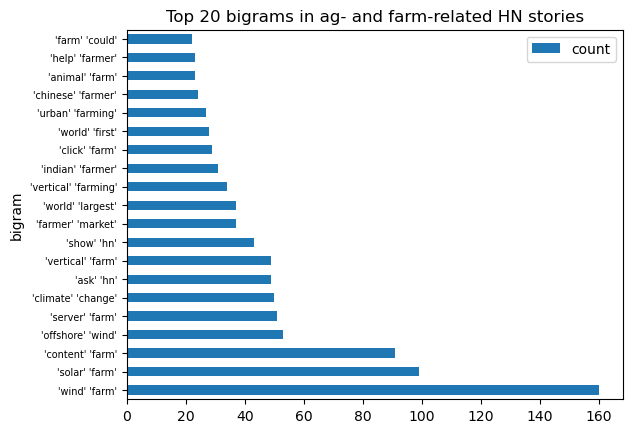

In [24]:
ax = top_20_bigrams.plot.barh(x='bigram', y='count', title='Top 20 bigrams in ag- and farm-related HN stories')
ax.tick_params(axis='y', labelsize=7)

The top 20 bigrams contain quite a few irrelevant bigrams (e.g. wind farm, solar farm, ask HN) so I think it would be best to examine the top 100 bigrams dataframe instead.

Using the bigrams relevant to agritech, I'll sift through and save a dataset that contains only stories relevant to this topic.

proposed process to vet titles: go down list of bigrams, pick out the agtech-related bigrams, filter out rows containing any one of these bigrams and save to a new df

In [50]:
# try filtering on one bigram
# if any str[i] in ['title_bigrams'] matches the selected bigram then return T else F
selection = [('vertical', 'farm'), ('vertical', 'farming')]
mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in selection if item in x))
ag_farm_df[mask]
# so this works!! so now i can create a selection containing the bigrams extracted using their indices

,title,type,score,comments,timestamp,url,title_tokens,title_lemmas,title_bigrams
128,vertical farming a farm on every floor,story,2,0.0,2009-08-24 13:38:00+00:00,http://www.nytimes.com/2009/08/24/opinion/24De...,"[vertical, farming, a, farm, on, every, floor]","[vertical, farming, a, farm, on, every, floor]","[(vertical, farming), (farming, a), (a, farm),..."
164,vertical farming,story,1,0.0,2009-11-30 02:14:53+00:00,http://techmeh.com/2009/11/vertical-farming-ge...,"[vertical, farming]","[vertical, farming]","[(vertical, farming)]"
272,vertical farming,story,1,0.0,2010-07-02 18:23:51+00:00,http://www.verticalfarm.com/designs.html,"[vertical, farming]","[vertical, farming]","[(vertical, farming)]"
324,why vertical farms are a crock,story,74,94.0,2010-09-17 16:32:02+00:00,http://www.monbiot.com/archives/2010/08/16/tow...,"[why, vertical, farms, are, a, crock]","[why, vertical, farm, are, a, crock]","[(why, vertical), (vertical, farm), (farm, are..."
337,vertical farms could make use of onhold constr...,story,6,4.0,2010-10-09 00:47:28+00:00,http://www.landartgenerator.org/blagi/archives...,"[vertical, farms, could, make, use, of, onhold...","[vertical, farm, could, make, use, of, onhold,...","[(vertical, farm), (farm, could), (could, make..."
...,...,...,...,...,...,...,...,...,...
4786,vertical farming quantum teleportation apple a...,story,1,NaN,2020-12-24 12:50:33+00:00,https://perceptions.substack.com/p/future-jist-16,"[vertical, farming, quantum, teleportation, ap...","[vertical, farming, quantum, teleportation, ap...","[(vertical, farming), (farming, quantum), (qua..."
4794,2acre vertical farm run by ai and robots outpr...,story,418,389.0,2020-12-27 22:47:38+00:00,https://www.intelligentliving.co/vertical-farm...,"[2acre, vertical, farm, run, by, ai, and, robo...","[2acre, vertical, farm, run, by, ai, and, robo...","[(2acre, vertical), (vertical, farm), (farm, r..."
4795,no vertical farms wont feed the world,story,4,0.0,2020-12-28 07:20:09+00:00,https://globalecoguy.org/no-vertical-farms-won...,"[no, vertical, farms, wont, feed, the, world]","[no, vertical, farm, wont, feed, the, world]","[(no, vertical), (vertical, farm), (farm, wont..."
4834,vertical farms grow veggies on site at restaur...,story,244,231.0,2021-01-20 19:52:58+00:00,https://newatlas.com/good-thinking/vertical-fi...,"[vertical, farms, grow, veggies, on, site, at,...","[vertical, farm, grow, veggie, on, site, at, r...","[(vertical, farm), (farm, grow), (grow, veggie..."


In [80]:
fm_selection = [('farm', 'management')]
fm_mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in fm_selection if item in x))
ag_farm_df[fm_mask]

,title,type,score,comments,timestamp,url,title_tokens,title_lemmas,title_bigrams
932,old mcdonald had an app farmlogs lands 1m to m...,story,66,20.0,2013-01-26 02:38:06+00:00,http://gigaom.com/2013/01/25/old-mcdonald-had-...,"[old, mcdonald, had, an, app, farmlogs, lands,...","[old, mcdonald, had, an, app, farmlogs, land, ...","[(old, mcdonald), (mcdonald, had), (had, an), ..."
2638,show hn tania an open source farm management ...,story,2,0.0,2017-07-11 07:50:44+00:00,https://github.com/Tanibox/tania,"[show, hn, tania, an, open, source, farm, mana...","[show, hn, tania, an, open, source, farm, mana...","[(show, hn), (hn, tania), (tania, an), (an, op..."
2678,dupont acquires farm management software granu...,story,2,0.0,2017-08-10 11:56:20+00:00,https://agfundernews.com/dupont-acquires-farm-...,"[dupont, acquires, farm, management, software,...","[dupont, acquires, farm, management, software,...","[(dupont, acquires), (acquires, farm), (farm, ..."
2860,tania why did we open source our farm manageme...,story,2,1.0,2017-12-26 11:19:15+00:00,http://tanibox.com/open-sourcing-tania/,"[tania, why, did, we, open, source, our, farm,...","[tania, why, did, we, open, source, our, farm,...","[(tania, why), (why, did), (did, we), (we, ope..."
2938,farm management system remote access to equip...,story,1,NaN,2018-02-13 12:18:19+00:00,https://www.eltima.com/farm-equipment-redirect...,"[farm, management, system, remote, access, to,...","[farm, management, system, remote, access, to,...","[(farm, management), (management, system), (sy..."
3480,show hn tania an open source farm management s...,story,5,0.0,2019-01-19 08:46:22+00:00,https://github.com/Tanibox/tania-core,"[show, hn, tania, an, open, source, farm, mana...","[show, hn, tania, an, open, source, farm, mana...","[(show, hn), (hn, tania), (tania, an), (an, op..."
3735,we prepare the saas version of tania our open ...,story,2,0.0,2019-06-21 11:30:48+00:00,https://usetania.org/blog/tania-saas-indiegogo...,"[we, prepare, the, saas, version, of, tania, o...","[we, prepare, the, saas, version, of, tania, o...","[(we, prepare), (prepare, the), (the, saas), (..."


In [25]:
# now i need to resave the top_100_bigrams with the parantheses and commas still in place 
# so that i can copy them easily into my list to create the mask
# construct 2-column df from dict
bigrams_freq_df2 = pd.DataFrame.from_dict(fdist, orient='index').reset_index()

# rename columns
bigrams_freq_df2 = bigrams_freq_df2.rename(columns={'index':'bigram', 0:'count'})

# sort by descending order
bigrams_freq_df2.sort_values(by='count', ascending = False)

# save top 100 into new df
top_100_bigrams2 = bigrams_freq_df2.nlargest(100,'count')
top_100_bigrams2

,bigram,count
30,"(wind, farm)",160
1608,"(solar, farm)",99
581,"(content, farm)",91
814,"(offshore, wind)",53
57,"(server, farm)",51
...,...,...
75,"(farm, work)",8
419,"(north, carolina)",8
781,"(local, farmer)",8
807,"(look, like)",8


In [81]:
top_100_bigrams2.loc[[1059, 458]]['bigram'].to_numpy()

# how to remove the indexes

array([('vertical', 'farm'), ('vertical', 'farming')], dtype=object)

In [82]:
# select bigrams based on their index and convert them to an array 
selection = bigrams_freq_df2.loc[[1059, 458, 397, 1318, 2553, 863, 1057, 4303, 5469, 2137, 2607, 2102, 4151, 6977, 2516, 2966, 4207, 6060, 
                                  8209, 2902, 7145, 1082, 3857, 1880, 3241, 2831,
                                  11442, 48, 5044, 8466, 300, 5936]]['bigram'].to_numpy()
print(selection)

[('vertical', 'farm') ('vertical', 'farming') ('urban', 'farming')
 ('indoor', 'farm') ('farmlogs', 'yc') ('john', 'deere')
 ('urban', 'agriculture') ('indoor', 'farming') ('farm', 'robot')
 ('modern', 'farming') ('precision', 'agriculture') ('urban', 'farm')
 ('agricultural', 'revolution') ('regenerative', 'agriculture')
 ('big', 'ag') ('cannabis', 'farm') ('farming', 'startup')
 ('smart', 'farming') ('tractor', 'hacking') ('ag', 'tech')
 ('transform', 'agriculture') ('robotic', 'farm') ('using', 'drone')
 ('shipping', 'container') ('robot', 'farm') ('farm', 'management')
 ('labgrown', 'food') ('agricultural', 'technology') ('led', 'light')
 ('autonomous', 'farm') ('tech', 'startup') ('indoor', 'vertical')]


Most of the bigrams I've chosen contain the words ag(ri) and farm(ing) already. Some notable exceptions are names of entities in the agtech space, such as John Deere (farm machinery) and FarmLogs (agtech startup).

In [83]:
# using a mask, select the rows in ag_farm_df which contain the bigrams in the selection array
mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in selection if item in x))
agtech_df = ag_farm_df[mask]
agtech_df

,title,type,score,comments,timestamp,url,title_tokens,title_lemmas,title_bigrams
14,un adopts israelisponsored resolution on agric...,story,1,-1.0,2007-12-27 11:00:33+00:00,http://www.export.gov.il/Eng/_News/Item.asp?Ca...,"[un, adopts, israelisponsored, resolution, on,...","[un, adopts, israelisponsored, resolution, on,...","[(un, adopts), (adopts, israelisponsored), (is..."
81,sons of migrant farmworkers cofound promising ...,story,1,0.0,2009-02-04 21:47:58+00:00,http://www.siliconvalley.com/news/ci_11620102?...,"[sons, of, migrant, farmworkers, cofound, prom...","[son, of, migrant, farmworkers, cofound, promi...","[(son, of), (of, migrant), (migrant, farmworke..."
107,urban farming movement like a revolution,story,2,0.0,2009-06-29 20:54:40+00:00,http://www.cnn.com/2009/LIVING/06/29/bia.urban...,"[urban, farming, movement, like, a, revolution]","[urban, farming, movement, like, a, revolution]","[(urban, farming), (farming, movement), (movem..."
128,vertical farming a farm on every floor,story,2,0.0,2009-08-24 13:38:00+00:00,http://www.nytimes.com/2009/08/24/opinion/24De...,"[vertical, farming, a, farm, on, every, floor]","[vertical, farming, a, farm, on, every, floor]","[(vertical, farming), (farming, a), (a, farm),..."
164,vertical farming,story,1,0.0,2009-11-30 02:14:53+00:00,http://techmeh.com/2009/11/vertical-farming-ge...,"[vertical, farming]","[vertical, farming]","[(vertical, farming)]"
...,...,...,...,...,...,...,...,...,...
4794,2acre vertical farm run by ai and robots outpr...,story,418,389.0,2020-12-27 22:47:38+00:00,https://www.intelligentliving.co/vertical-farm...,"[2acre, vertical, farm, run, by, ai, and, robo...","[2acre, vertical, farm, run, by, ai, and, robo...","[(2acre, vertical), (vertical, farm), (farm, r..."
4795,no vertical farms wont feed the world,story,4,0.0,2020-12-28 07:20:09+00:00,https://globalecoguy.org/no-vertical-farms-won...,"[no, vertical, farms, wont, feed, the, world]","[no, vertical, farm, wont, feed, the, world]","[(no, vertical), (vertical, farm), (farm, wont..."
4834,vertical farms grow veggies on site at restaur...,story,244,231.0,2021-01-20 19:52:58+00:00,https://newatlas.com/good-thinking/vertical-fi...,"[vertical, farms, grow, veggies, on, site, at,...","[vertical, farm, grow, veggie, on, site, at, r...","[(vertical, farm), (farm, grow), (grow, veggie..."
4836,police discover first cannabis farm in london ...,story,1,0.0,2021-01-20 21:18:50+00:00,https://www.reuters.com/article/us-britain-pol...,"[police, discover, first, cannabis, farm, in, ...","[police, discover, first, cannabis, farm, in, ...","[(police, discover), (discover, first), (first..."


Using the bigrams has allowed me to reduce the wide query results from 4901 rows to 292 rows containing ag-tech related stories.

However, there are still a couple of bigrams which I'm on the fence about including because some of the stories might not be relevant. For instance bigrams like: machine learning, farmer build, etc.  
So I'll just filter for those rows to check.

In [27]:
# select bigrams based on their index and convert them to an array 
ml_selection = top_100_bigrams2.loc[[3191]]['bigram'].to_numpy()

# using a mask, select the rows in ag_farm_df which contain the bigrams in the selection array
ml_mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in ml_selection if item in x))
ag_farm_df[ml_mask]

,title,type,score,comments,timestamp,url,title_tokens,title_lemmas,title_bigrams
1052,setting up a machine learning farm with spot i...,story,3,0.0,2013-06-25 17:03:02+00:00,http://blog.diffbot.com/setting-up-a-machine-l...,"[setting, up, a, machine, learning, farm, with...","[setting, up, a, machine, learning, farm, with...","[(setting, up), (up, a), (a, machine), (machin..."
1325,data center with a brain google using machine ...,story,1,0.0,2014-05-28 11:33:08+00:00,http://www.datacenterknowledge.com/archives/20...,"[data, center, with, a, brain, google, using, ...","[data, center, with, a, brain, google, using, ...","[(data, center), (center, with), (with, a), (a..."
2884,applepicking robots machine learning ag tech c...,story,1,0.0,2018-01-21 17:48:37+00:00,http://www.businessinsider.com/apple-picking-r...,"[applepicking, robots, machine, learning, ag, ...","[applepicking, robot, machine, learning, ag, t...","[(applepicking, robot), (robot, machine), (mac..."
2901,aquabyte raises 35m to add machine learning to...,story,1,NaN,2018-01-30 20:48:23+00:00,https://www.forbes.com/sites/alexknapp/2018/01...,"[aquabyte, raises, 35m, to, add, machine, lear...","[aquabyte, raise, 35m, to, add, machine, learn...","[(aquabyte, raise), (raise, 35m), (35m, to), (..."
3420,machine learning is gradually changing modern ...,story,79,5.0,2018-12-14 07:27:26+00:00,http://precisionagricultu.re/how-machine-learn...,"[machine, learning, is, gradually, changing, m...","[machine, learning, is, gradually, changing, m...","[(machine, learning), (learning, is), (is, gra..."
3488,ai and machine learning can improve agricultur...,story,2,0.0,2019-01-23 23:18:27+00:00,https://farmingfirst.org/digital-revolution-ag...,"[ai, and, machine, learning, can, improve, agr...","[ai, and, machine, learning, can, improve, agr...","[(ai, and), (and, machine), (machine, learning..."
3784,machine learning in agriculture applications a...,story,1,NaN,2019-07-18 17:02:32+00:00,https://www.datasciencecentral.com/profiles/bl...,"[machine, learning, in, agriculture, applicati...","[machine, learning, in, agriculture, applicati...","[(machine, learning), (learning, in), (in, agr..."
3926,tackling climate change with machine learning ...,story,3,0.0,2019-09-25 08:10:06+00:00,https://blog.codecentric.de/en/2019/09/tacklin...,"[tackling, climate, change, with, machine, lea...","[tackling, climate, change, with, machine, lea...","[(tackling, climate), (climate, change), (chan..."
3944,want a really hard machine learning problem tr...,story,5,0.0,2019-10-04 15:08:54+00:00,https://spectrum.ieee.org/view-from-the-valley...,"[want, a, really, hard, machine, learning, pro...","[want, a, really, hard, machine, learning, pro...","[(want, a), (a, really), (really, hard), (hard..."
3951,want a hard machine learning problem try agric...,story,1,NaN,2019-10-08 23:23:57+00:00,https://spectrum.ieee.org/view-from-the-valley...,"[want, a, hard, machine, learning, problem, tr...","[want, a, hard, machine, learning, problem, tr...","[(want, a), (a, hard), (hard, machine), (machi..."


It seems like the titles which contain both 'machine learning' and 'agri/ agtech' are most relevant. Should I add those to the agtech_df (by using str.contains and then append)?

In [28]:
# select bigrams based on their index and convert them to an array 
fb_selection = top_100_bigrams2.loc[[1644]]['bigram'].to_numpy()

# using a mask, select the rows in ag_farm_df which contain the bigrams in the selection array
ml_mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in fb_selection if item in x))
ag_farm_df[ml_mask]

,title,type,score,comments,timestamp,url,title_tokens,title_lemmas,title_bigrams
530,chinese farmer builds robots in his spare time,story,2,0.0,2011-05-02 07:49:38+00:00,http://www.bbc.co.uk/news/world-asia-pacific-1...,"[chinese, farmer, builds, robots, in, his, spa...","[chinese, farmer, build, robot, in, his, spare...","[(chinese, farmer), (farmer, build), (build, r..."
633,chinese farmer builds eightpropeller flying sa...,story,1,0.0,2011-09-24 19:45:48+00:00,http://io9.com/5843571/chinese-farmer-builds-e...,"[chinese, farmer, builds, eightpropeller, flyi...","[chinese, farmer, build, eightpropeller, flyin...","[(chinese, farmer), (farmer, build), (build, e..."
847,chinese farmer builds his own prosthetic limb,story,5,1.0,2012-08-16 22:02:35+00:00,http://kotaku.com/5935251/chinese-farmer-is-bo...,"[chinese, farmer, builds, his, own, prosthetic...","[chinese, farmer, build, his, own, prosthetic,...","[(chinese, farmer), (farmer, build), (build, h..."
1025,chinese farmer builds his own bionic arms,story,1,-1.0,2013-05-26 19:22:51+00:00,http://www.liveleak.com/view?i=1a7_1369470293#...,"[chinese, farmer, builds, his, own, bionic, arms]","[chinese, farmer, build, his, own, bionic, arm]","[(chinese, farmer), (farmer, build), (build, h..."
1063,chinese farmer builds bionic arms for under 500,story,4,1.0,2013-07-12 14:34:23+00:00,http://ntdtv.org/en/news/world/asia/2013-05-24...,"[chinese, farmer, builds, bionic, arms, for, u...","[chinese, farmer, build, bionic, arm, for, und...","[(chinese, farmer), (farmer, build), (build, b..."
1153,the 150 hobbit hole farmer builds a cosy cob h...,story,3,0.0,2013-11-26 15:57:48+00:00,http://www.dailymail.co.uk/news/article-251315...,"[the, 150, hobbit, hole, farmer, builds, a, co...","[the, 150, hobbit, hole, farmer, build, a, cos...","[(the, 150), (150, hobbit), (hobbit, hole), (h..."
1247,australian farmer builds own hydroelectric pow...,story,2,0.0,2014-03-23 06:12:05+00:00,http://www.abc.net.au/news/2014-03-23/tasmania...,"[australian, farmer, builds, own, hydroelectri...","[australian, farmer, build, own, hydroelectric...","[(australian, farmer), (farmer, build), (build..."
1258,chinese farmers build their own incredible tra...,story,1,NaN,2014-03-30 15:06:14+00:00,https://ca.news.yahoo.com/blogs/daily-buzz/chi...,"[chinese, farmers, build, their, own, incredib...","[chinese, farmer, build, their, own, incredibl...","[(chinese, farmer), (farmer, build), (build, t..."
1360,japanese farmer builds hightech indoor veggie ...,story,81,42.0,2014-07-10 14:52:09+00:00,http://www.gereports.com/post/91250246340/lett...,"[japanese, farmer, builds, hightech, indoor, v...","[japanese, farmer, build, hightech, indoor, ve...","[(japanese, farmer), (farmer, build), (build, ..."
1541,chinese farmer builds his own bionic arms you...,story,3,0.0,2015-02-22 04:51:26+00:00,https://www.youtube.com/watch?v=aSvwsforehU,"[chinese, farmer, builds, his, own, bionic, ar...","[chinese, farmer, build, his, own, bionic, arm...","[(chinese, farmer), (farmer, build), (build, h..."


While there is one story related to indoor farming (index:1360), the rest of the stories look like they are irrelevant.

To make things less tedious, I've decided to leave out ambiguous bigrams which may or may not be related to agtech.

## Yearly trends in agtech coverage

In [84]:
agtech_df.agg({'score': ['mean', 'std', 'max', 'min', 'sum'], 'comments': ['mean', 'std', 'max', 'min', 'sum']})

,score,comments
mean,17.528000,12.302752
std,57.242038,45.833355
max,511.000000,389.000000
min,1.000000,-1.000000
sum,6573.000000,4023.000000


In [85]:
# create truncate timestamp column to year
agtech_df['year'] = pd.DatetimeIndex(agtech_df['timestamp']).year

C:\Users\fangn\anaconda3\envs\hackernews\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
# group stories by year
agtech_df.groupby(['year'], as_index=False).agg({"title":"count", "comments":"sum", "score":"sum"})

,year,title,comments,score
0,2007,1,-1.0,1
1,2009,4,0.0,6
2,2010,9,157.0,166
3,2011,8,-4.0,10
4,2012,14,34.0,136
5,2013,16,66.0,192
6,2014,20,52.0,181
7,2015,39,299.0,435
8,2016,35,218.0,454
9,2017,51,726.0,1533


In [87]:
# same table but with column heading relabelled using pd.NamedAgg
agtech_yearly = agtech_df.groupby('year').agg(
                      stories_count = pd.NamedAgg(column = 'title', aggfunc="count"),
                      total_score = pd.NamedAgg(column = 'score', aggfunc="sum"),
                      total_comments = pd.NamedAgg(column = 'comments', aggfunc="sum"))
agtech_yearly

,stories_count,total_score,total_comments
year,,,
2007,1,1,-1.0
2009,4,6,0.0
2010,9,166,157.0
2011,8,10,-4.0
2012,14,136,34.0
2013,16,192,66.0
2014,20,181,52.0
2015,39,435,299.0
2016,35,454,218.0


In [89]:
# drop years before 2010, and 2021 since the year hasn't concluded
agtech_yearly = agtech_yearly.drop({2007, 2009, 2021})

In [90]:
agtech_yearly

,stories_count,total_score,total_comments
year,,,
2010,9,166,157.0
2011,8,10,-4.0
2012,14,136,34.0
2013,16,192,66.0
2014,20,181,52.0
2015,39,435,299.0
2016,35,454,218.0
2017,51,1533,726.0
2018,68,1103,701.0


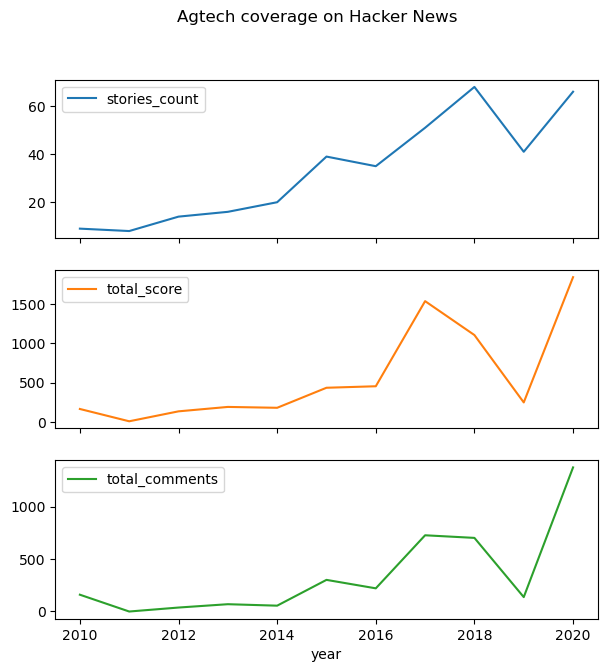

In [91]:
# plot total stories, comments, scores per year
axes = agtech_yearly.plot.line(subplots=True, title='Agtech coverage on Hacker News', figsize=(7,7))

Might also do other plot to see average score and comments in each year?

## K-means clustering on the titles

Goal: to group the title of the stories into different clusters